# The Bayesian landscape
When we setup a Bayesian inference problem with N unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are `Uniform(0,5)`, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely).

In [7]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from default_settings import *

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Text(0.5, 0.92, 'Uniform prior landscape; alternate view')

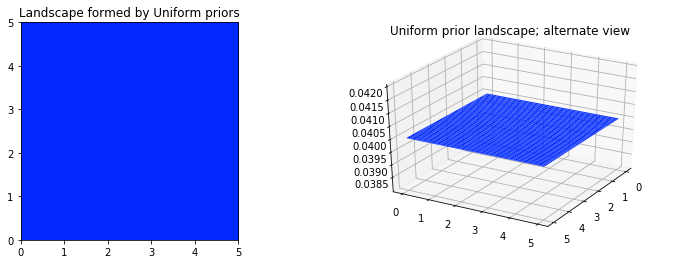

In [3]:
jet = plt.cm.jet
fig = plt.figure(figsize=(12.5, 4))
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Landscape formed by Uniform priors')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title('Uniform prior landscape; alternate view')
                     

Alternatively, if the two priors are `Exp(3)` and `Exp(10)`, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location.

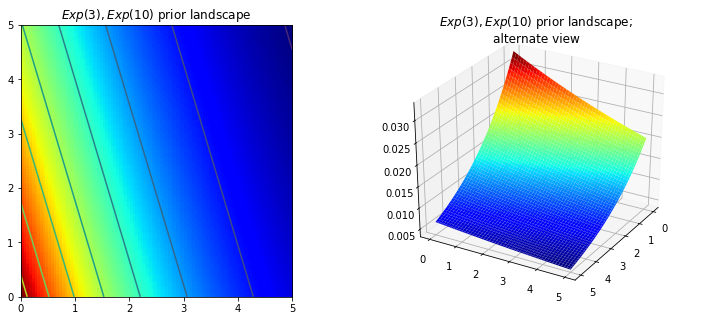

In [4]:
fig = plt.figure(figsize=(12.5, 5))
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',cmap=jet, extent=(0, 5, 0, 5))
plt.title('$Exp(3), Exp(10)$ prior landscape')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional.

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling* and *stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the *posterior distribution*.

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape.

In [33]:
# create the observed data
# sample size of data we observe, trying to vary this
N = 1

# the true parameters, but of course we don't see these values
lambda_1_true = float(1.)
lambda_2_true = float(3.)

# We see the data generated, dependent on the above two values.
data = tf.concat([
    tfd.Poisson(rate=lambda_1_true).sample(sample_shape=(N, 1), seed=4),
    tfd.Poisson(rate=lambda_2_true).sample(sample_shape=(N, 1), seed=8)
], axis=1)
data_ = evaluate(data)
print('observed (2-dimensional, sample size= %d):' % N, data_)

# Plotting details.
x_ = y_ = np.linspace(0.01, 5, 100)
likelihood_x_ = evaluate(tfd.Poisson(rate=x_).prob(data_[:, 0]))
likelihood_y_ = evaluate(tfd.Poisson(rate=y_).prob(data_[:, 1]))
L_ = evaluate(tf.matmul(tf.expand_dims(likelihood_x_, 1), 
                        tf.expand_dims(likelihood_y_, 0)))

observed (2-dimensional, sample size= 1): [[3. 4.]]


In [37]:
tf.matmul(tf.expand_dims(likelihood_x_, 1), 
                        tf.expand_dims(likelihood_y_, 0))

<tf.Tensor 'MatMul_21:0' shape=(100, 100) dtype=float64>

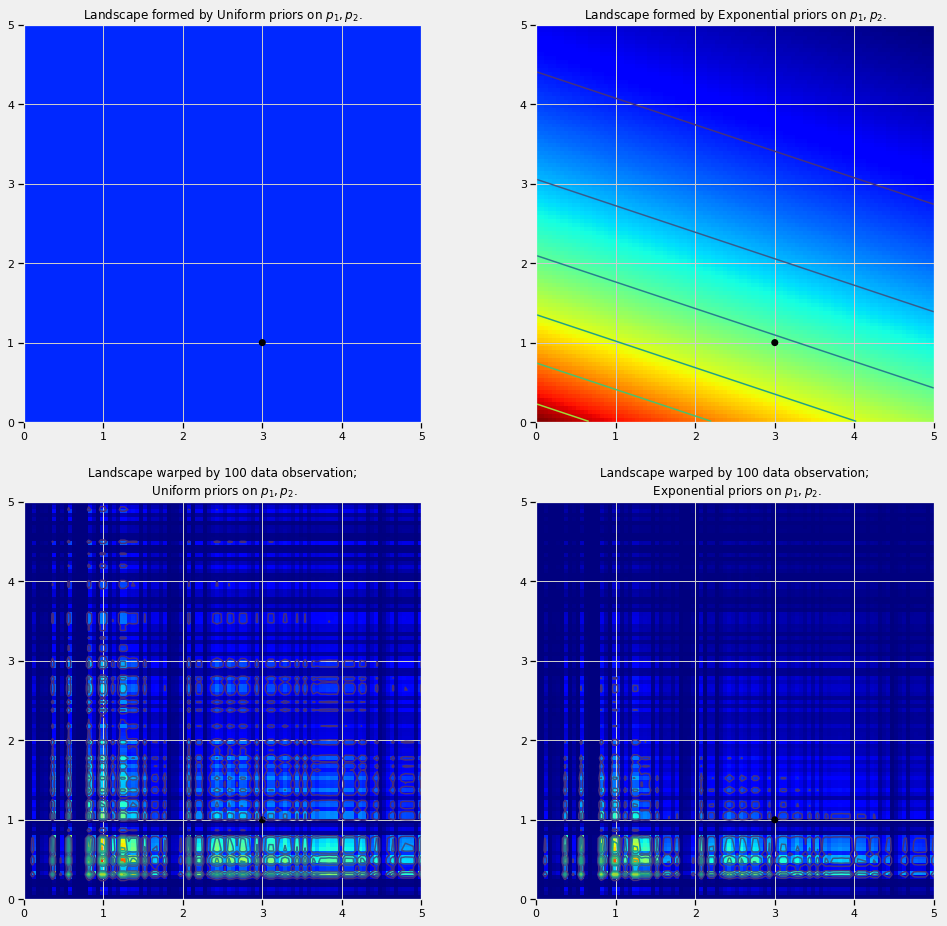

In [32]:
f, axes = plt.subplots(2, 2, figsize=(15.0, 15.0))

# Subplot for regular uniform
uni_x_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.to_float(x_)))
m = np.median(uni_x_[uni_x_ > 0])
uni_x_[uni_x_ == 0] = m
uni_y_ = evaluate(tfd.Uniform(low=0., high=5.).prob(tf.to_float(y_)))
m = np.median(uni_y_[uni_y_ > 0])
uni_y_[uni_y_ == 0] = m
M_ = evaluate(tf.matmul(tf.expand_dims(uni_x_, 1), tf.expand_dims(uni_y_, 0)))

ax = axes[0][0]
im = ax.imshow(M_, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
ax.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolor='none')
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_title(r"Landscape formed by Uniform priors on $p_1, p_2$.")

# SUBPLOT for Uniform + Data point
ax = axes[1][0]
ax.contour(x_, y_, M_ * L_)
im = ax.imshow(M_ * L_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
ax.set_title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
ax.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

# SUBPLOT for regular Exponential
exp_x_ = evaluate(tfd.Exponential(rate=.3).prob(tf.to_float(x_)))
exp_x_[np.isnan(exp_x_)] = exp_x_[1]
exp_y_ = evaluate(tfd.Exponential(rate=.10).prob(tf.to_float(y_)))
exp_y_[np.isnan(exp_y_)] = exp_y_[1]
M_ = evaluate(tf.matmul(tf.expand_dims(exp_x_, 1), tf.expand_dims(exp_y_, 0)))

ax = axes[0][1]
ax.contour(x_, y_, M_)
im = ax.imshow(M_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
ax.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_title("Landscape formed by Exponential priors on $p_1, p_2$.")

# SUBPLOT for Exponential + Data point
ax = axes[1][1]
# This is the likelihood times prior, that results in the posterior.
ax.contour(x_, y_, M_ * L_)
im = ax.imshow(M_ * L_, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

ax.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
ax.set_title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5);
